# Deskripsi Proyek

Bijih yang ditambang mengalami pemrosesan primer untuk mendapatkan campuran bijih atau feed yang lebih kasar. Hasil dari proses itu digunakan sebagai bahan baku untuk flotasi (alias proses untuk menghasilkan konsentrat yang lebih kasar). Setelah dilakukan flotasi, hasil partikel-partikelnya pun melewati proses pemurnian dua tahap yakni:

1. Flotasi

    Campuran bijih emas dimasukkan ke dalam tangki pelampung untuk mendapatkan konsentrat Au dan ekor yang lebih kasar (residu produk dengan tingkat konsentrasi logam berharga yang rendah).
Kestabilan proses ini dipengaruhi oleh volatilitas dan keadaan fisikokimia yang tidak optimal dari pulp flotasi (campuran partikel padat dan cairan).


2. Pemurnian

    Konsentrat Au yang lebih kasar mengalami dua tahap pemurnian. Setelah proses pemurnian, kita pun akan memiliki tingkat konsentrasi logam akhir dan ekor baru.


Data ini diindeks sesuai dengan tanggal dan waktu perolehannya (fitur date). Terkait waktu, parameter yang letaknya bersebelahan umumnya bersifat mirip.
Sebagian parameter tidak tersedia karena pengukuran dan/atau penghitungannya dilakukan jauh setelahnya. Karena itu, beberapa fitur yang ada di training set mungkin tidak ada di test set. Test set-nya pun juga tidak memuat target.
Dataset sumber memuat training dan test set dengan semua fitur-fiturnya.



## Load Library

In [105]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')

## Load dataset

In [106]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

### Deskripsi Data

#### Proses teknologi
- Rougher feed — bahan mentah untuk proses flotasi
- Rougher additions (atau reagent additions) — reagen untuk flotasi: Xanthate, Sulphate, Depressant
- Xanthate — penggerak atau aktivator flotasi
- Sulphate — natrium sulfida, khusus untuk proses ini
- Depressant — natrium silikat
- Rougher process — flotasi
- Rougher tails — residu produk
- Float banks — unit flotasi
- Cleaner process — pemurnian
- Rougher Au — konsentrat emas yang lebih kasar
- Final Au — konsentrat emas akhir

#### Parameter dari setiap tahapan yang tersedia
- air amount — volume udara
- fluid levels
- feed size — ukuran partikel umpan
- feed rate

#### Penamaan fitur

Berikut merupakan cara untuk memberikan nama pada fitur-fitur yang ada:

**[stage].[parameter_type].[parameter_name]**

**Contoh: rougher.input.feed_ag**

#### Nilai yang memungkinkan untuk [stage]:
- rougher — flotasi
- primary_cleaner — pemurnian pertama
- secondary_cleaner — pemurnian kedua
- final — karakteristik akhir

#### Nilai yang memungkinkan untuk [parameter_type]:
- input — parameter bahan mentah
- output — parameter produk
- state — parameter yang menunjukkan karakteristik tahapan saat ini
- calculation — perhitungan karakteristik

The equation of a line is $y = mx + b$, where $m$ is the slope and $b$ is the y-intercept.


#### Perhitungan untuk perolehan

Proses perolehan emas dari bijih emas akan disimulasikan dengan rumus berikut:

$Perolehan = \frac{C * (F-T)}{F * (C-T)} * 100\%$


Di mana:
- C — persentase emas dalam konsentrat tepat setelah proses flotasi (untuk menemukan perolehan konsentrat yang lebih kasar)/setelah dilakukan pemurnian (untuk menemukan perolehan konsentrat akhir)

- F — persentase emas dalam feed sebelum proses flotasi (untuk menemukan perolehan konsentrat yang lebih kasar)/ dalam konsentrat tepat setelah proses flotasi (untuk menemukan perolehan konsentrat akhir)

- T — persentase emas dalam ekor yang lebih kasar, tepat setelah proses flotasi (untuk menemukan perolehan konsentrat yang lebih kasar)/setelah dilakukan pemurnian (untuk menemukan perolehan konsentrat akhir)

#### Metrik evaluasi

Untuk menyelesaikan masalah yang ada, kita akan menggunakan sMAPE (symmetric Mean Absolute Percentage Error) atau kesalahan persentase absolut rata-rata simetris. 

Berikut adalah cara untuk menghitung sMAPE:

$sMAPE = \frac{1}{N}\sum\limits_{i = 1}^{p}\frac{|y_{i}-\hat{y_{i}}|}{(|y_{i}|+|\hat{y_{i}}|)/2} * 100\%$

Di mana:
- $y_{i}$ - Nilai target untuk observasi dengan indeks i dalam set yang digunakan untuk mengukur kualitas.

- $\hat{y_{i}}$ - Nilai prediksi untuk observasi dengan indeks i, misalnya, dalam sampel uji atau test sample.

- $N$ - Jumlah observasi pada sampel.

- $\sum\limits_{i=1}^{N}$ - Penjumlahan semua observasi sampel (nilai i adalah 0 sampai N).

#### Target analisis

Analisis dilakukan untuk memprediksi kedua nilai berikut:
- Perolehan konsentrat yang lebih kasar **rougher.output.recovery**
- Perolehan konsentrat akhir **final.output.recovery**

Metrik terakhir mencakup dua nilai:

$sMAPE (akhir) = 25\% * sMAPE(rougher) + 75\% * sMAPE(final) $

In [107]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [108]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [109]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [110]:
df_train.isna().mean().sort_values()

date                                                  0.000000
primary_cleaner.input.feed_size                       0.000000
rougher.calculation.floatbank11_sulfate_to_au_feed    0.001601
rougher.calculation.floatbank10_sulfate_to_au_feed    0.001601
rougher.calculation.sulfate_to_au_concentrate         0.001601
                                                        ...   
secondary_cleaner.output.tail_sol                     0.117794
rougher.output.tail_au                                0.133393
rougher.output.tail_sol                               0.133393
rougher.output.tail_ag                                0.133452
rougher.output.recovery                               0.152610
Length: 87, dtype: float64

In [111]:
df_test.isna().mean().sort_values()

date                                          0.000000
primary_cleaner.input.feed_size               0.000000
rougher.state.floatbank10_c_level             0.002732
rougher.state.floatbank10_d_level             0.002732
rougher.state.floatbank10_e_level             0.002732
rougher.state.floatbank10_f_level             0.002732
secondary_cleaner.state.floatbank2_a_level    0.002732
secondary_cleaner.state.floatbank2_b_level    0.002732
secondary_cleaner.state.floatbank3_a_level    0.002732
secondary_cleaner.state.floatbank3_b_air      0.002732
secondary_cleaner.state.floatbank3_b_level    0.002732
secondary_cleaner.state.floatbank4_a_air      0.002732
secondary_cleaner.state.floatbank4_a_level    0.002732
secondary_cleaner.state.floatbank4_b_air      0.002732
secondary_cleaner.state.floatbank4_b_level    0.002732
secondary_cleaner.state.floatbank5_a_air      0.002732
secondary_cleaner.state.floatbank5_a_level    0.002732
secondary_cleaner.state.floatbank5_b_air      0.002732
secondary_

In [112]:
df_full.isna().mean().sort_values()

date                                        0.000000
primary_cleaner.input.feed_size             0.000000
primary_cleaner.state.floatbank8_d_level    0.001893
primary_cleaner.state.floatbank8_c_level    0.001893
primary_cleaner.state.floatbank8_b_level    0.001893
                                              ...   
rougher.input.floatbank11_xanthate          0.099357
rougher.output.tail_au                      0.120444
rougher.output.tail_sol                     0.120444
rougher.output.tail_ag                      0.120488
rougher.output.recovery                     0.137304
Length: 87, dtype: float64

In [113]:
print('Number of df_train duplicated :',df_train.duplicated().sum())
print('Number of df_test duplicated  :',df_test.duplicated().sum())
print('Number of df_full duplicated  :',df_full.duplicated().sum())

Number of df_train duplicated : 0
Number of df_test duplicated  : 0
Number of df_full duplicated  : 0


In [114]:
print('Shape of df_train  :',df_train.shape)
print('Shape of df_test   :',df_test.shape)
print('Shape of df_full   :',df_full.shape)


Shape of df_train  : (16860, 87)
Shape of df_test   : (5856, 53)
Shape of df_full   : (22716, 87)


Dari hasil yang didapatkan, ditemukan banyak missing values dari setiap dataset yang perlu diperbaiki. Bentuk dataset juga menunjukan terdapat 34 kolom yang tidak terdapat pada df_test.

## Data Preparation

### MAE output.recovery

In [115]:
df_formula = df_train[['rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au','rougher.output.recovery']]
df_formula.head()

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
0,19.793808,6.486150,1.170244,87.107763
1,20.050975,6.478583,1.184827,86.843261
2,19.737170,6.362222,1.162562,86.842308
3,19.320810,6.118189,1.079755,87.226430
4,19.216101,5.663707,1.012642,86.688794


In [116]:
# Formula untuk mencari perolehan emas
C = 'rougher.output.concentrate_au'
F = 'rougher.input.feed_au'
T = 'rougher.output.tail_au'
df_numerator = df_formula[C]*(df_formula[F]-df_formula[T])
df_denominator = df_formula[F]*(df_formula[C]-df_formula[T])

In [117]:
formula = round((df_formula[C]*(df_formula[F]-df_formula[T]))/(df_formula[F]*(df_formula[C]-df_formula[T])) * 100, 6)
formula

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 16860, dtype: float64

In [118]:
pd.DataFrame({'formula':formula,'output.recovery':df_formula['rougher.output.recovery']})

,formula,output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
16855,89.574376,89.574376
16856,87.724007,87.724007
16857,88.890579,88.890579
16858,89.858126,89.858126


In [119]:
# Dalam penghitungan missing value pada numerator diubah menjadi 0 dan pada denominator menjadi 1 agar tidak terjadi masalah dalam penghitungan
df_numerator = df_numerator.fillna(0)
df_denominator = df_denominator.fillna(1)
df_formula['rougher.output.recovery_formula'] = (df_numerator/df_denominator) * 100

In [120]:
comparison = pd.DataFrame({'formula':df_formula['rougher.output.recovery_formula'],'output.recovery':df_formula['rougher.output.recovery']})

In [121]:
comparison = comparison.fillna(0)
comparison = comparison.replace(np.inf, 0)
comparison = comparison.replace(np.NINF, 0)
comparison['formula'] = round(comparison['formula'], 6)
comparison['output.recovery'] = round(comparison['output.recovery'], 6)

In [122]:
comparison.isna().sum()

formula            0
output.recovery    0
dtype: int64

In [123]:
print('MAE sebelum missing value diubah menjadi 0:', (df_formula['rougher.output.recovery_formula'] - df_formula['rougher.output.recovery'] ).abs().mean())
print('MAE sesudah missing value diubah menjadi 0:', (comparison['formula'] - comparison['output.recovery'] ).abs().mean())


MAE sebelum missing value diubah menjadi 0: 9.303415616264301e-15
MAE sesudah missing value diubah menjadi 0: 48.73524134365362


Dari formula yang diberikan ditemukan 2 MAE. Dataset pada df_formula memiliki banyak nilai hilang dan beberapa nilai inf yang belum diubah menjadi 0 dan hasil MAEnya adalah 9.30341e-15. Sementara itu, dataset pada **comparison** nilai hilang dan nilai inf telah diubah menjadi 0 sehingga hasil MAEnya menjadi 48.735.

Kedua nilai MAE yang ditemukan ini berbeda drastis karena nilai hilang dan inf pada dataset df_formula diabaikan dalam penghitungan MAE sementara pada dataset **comparison** yang nilai hilang dan nilai infnya telah diubah menjadi 0, dihitung dalam MAE. 

### Parameter yang tidak terdapat dalam test set

Pada df_test terdapat 34 kolom yang hilang dari df_train dan df_full. Kolom-kolom tersebut dapat dilihat pada sel berikut ini.

In [124]:
missing_test_columns = set(list(df_train.columns.values))- set(list(df_test.columns.values))
missing_test_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [125]:
df_full[missing_test_columns].dtypes

rougher.output.tail_pb                                float64
rougher.output.concentrate_sol                        float64
primary_cleaner.output.tail_pb                        float64
primary_cleaner.output.concentrate_pb                 float64
final.output.tail_au                                  float64
final.output.concentrate_au                           float64
final.output.tail_ag                                  float64
secondary_cleaner.output.tail_ag                      float64
rougher.output.tail_sol                               float64
rougher.output.recovery                               float64
rougher.output.tail_ag                                float64
rougher.output.concentrate_ag                         float64
primary_cleaner.output.tail_au                        float64
secondary_cleaner.output.tail_au                      float64
rougher.calculation.floatbank10_sulfate_to_au_feed    float64
primary_cleaner.output.concentrate_sol                float64
rougher.

Kolom yang hilang tidak dapat ditemukan kembali ke dalam df_test, karena itu dalam proses modeling kita akan menggunakan fitur yang terdapat pada kolom df_test saja.

### Pre-Processing Data

#### Missing Value

In [126]:
columns_used = df_test.columns.values.tolist()
columns_used.append('rougher.output.recovery')
columns_used.append('final.output.recovery')

In [127]:
# Dalam modelling hanya akan menggunakan kolom yang terdapat pada df_test
df_train_fixed = df_train[columns_used]

In [128]:
# Mengambil nilai yang tidak hilang pada recovery
df_train_fixed = df_train_fixed[df_train_fixed['rougher.output.recovery'].notnull()].reset_index(drop = True) 
df_train_fixed = df_train_fixed[df_train_fixed['final.output.recovery'].notnull()].reset_index(drop = True) 

In [129]:
df_train_fixed.shape, df_test.shape

((14149, 55), (5856, 53))

In [130]:
# Nilai hilang akan diisi dengan median dari setiap fitur, maka df_train_fixed dan df_test digabung terlebih dahulu agar tidak ada perbedaan nilai median 
# dalam pengisian nilai hilang
df_full_fixed = pd.concat([df_train_fixed, df_test])

In [131]:
# Training menggunakan 55 kolom
# Test wajib menggunakan 55 kolom

In [132]:
df_full_fixed.isna().mean().sort_values(ascending = False)

final.output.recovery                         0.292727
rougher.output.recovery                       0.292727
rougher.input.floatbank11_xanthate            0.039040
rougher.state.floatbank10_e_air               0.022644
primary_cleaner.input.sulfate                 0.016096
primary_cleaner.input.depressant              0.015796
rougher.input.floatbank10_sulfate             0.014296
primary_cleaner.input.xanthate                0.013297
secondary_cleaner.state.floatbank2_a_air      0.011847
rougher.input.feed_size                       0.008298
rougher.input.feed_sol                        0.007248
rougher.input.floatbank10_xanthate            0.006548
rougher.input.feed_pb                         0.005799
rougher.input.floatbank11_sulfate             0.004549
rougher.input.feed_rate                       0.002399
secondary_cleaner.state.floatbank2_b_air      0.002199
secondary_cleaner.state.floatbank3_a_air      0.001900
secondary_cleaner.state.floatbank4_a_air      0.001100
primary_cl

In [133]:
# Mengambil [2:-2] karena nilai diluar hal tersebut tidak perlu diperbaiki pada bagian ini
for col in df_full_fixed.isna().mean().sort_values(ascending = False)[2:-2].index:
    median_cols = df_full_fixed[col].median()
    df_full_fixed[col] = df_full_fixed[col].fillna(median_cols)

In [134]:
# Dataset yang sudah diperbaiki dipisah kembali menjadi test set dan train set di mana test set mengambil dataset yang nilai recoverynya missing
df_test_final = df_full_fixed[df_full_fixed['rougher.output.recovery'].isna()]
df_test_final = df_test_final.drop(columns = ['rougher.output.recovery', 'final.output.recovery'])

df_train_final = df_full_fixed[df_full_fixed['rougher.output.recovery'].notnull()].reset_index(drop = True)

Karena terdapat beberapa kolom hilang dalam df_test, kolom-kolom tersebut akan dihapus dari dataset df_train dan df_full terlebih dahulu agar dapat digunakan dalam modeling. 

Dataset df_test dan df_train yang kolomnya sudah dihapus lalu digabung menjadi satu untuk mencari median setiap kolom yang akan digunakan untuk mengisi nilai hilan pada kolom tersebut. Lalu, kedua dataset dipisah kembali menggunakan kolom **'rougher.output.recovery**. Jika nilai dalam kolom tersebut berupa nilai hilang maka akan dimasukkan ke dalam df_test jika tidak maka akan dimasukkan ke dalam df_train.

Hasil akhir akan disimpan kedalam df_train_final dan df_test_final.

## EDA

### Perubahan konsentrasi logam (Au, Ag, Pb), pada setiap tahap pemurniannya

In [135]:
purification_steps = ['rougher.input.feed_{}',
                      'rougher.output.concentrate_{}',
                      'primary_cleaner.output.concentrate_{}',
                      'final.output.concentrate_{}']

# Dalam membuat plot, tetap menggunakan dataset df_full karena terdapat fitur yang tidak terdapat dalam df_full_fixed untuk membuat plot
def plot_concentrate(metal):
    steps = [s.format(metal) for s in purification_steps]
    for step in steps:
        plt.hist(df_full[step], alpha = 0.5, bins = 20)
    plt.legend(steps)

def mean_concentrate(metal):
    steps = [s.format(metal) for s in purification_steps]
    for step in steps:    
        print('Average', step,'     :', df_full[step].mean())

Text(0.5, 1.0, 'Gold Concentration Change')

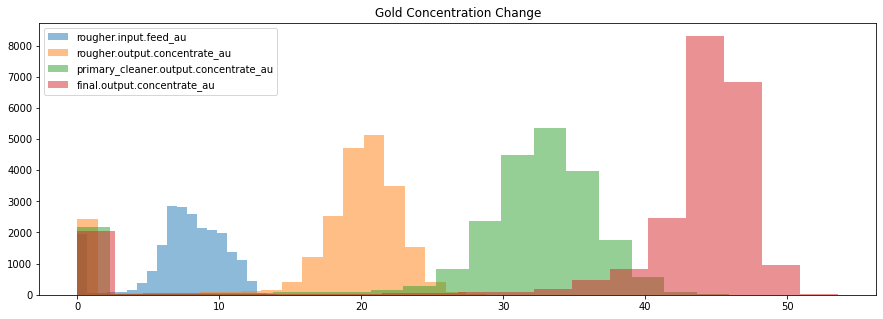

In [136]:
plt.figure(figsize = (15,5))
plot_concentrate('au')
plt.title('Gold Concentration Change')

In [137]:
mean_concentrate('au')

Average rougher.input.feed_au      : 7.565837755623329
Average rougher.output.concentrate_au      : 17.879538203033487
Average primary_cleaner.output.concentrate_au      : 29.2122887022116
Average final.output.concentrate_au      : 40.001171896007136


Ditemukan konsentrasi emas tiap tahapnya meningkat terus dari inputnya dengan rata-rata 7.57 sampai akhirnya mencapai 40.00.

Text(0.5, 1.0, 'Silver Concentration Change')

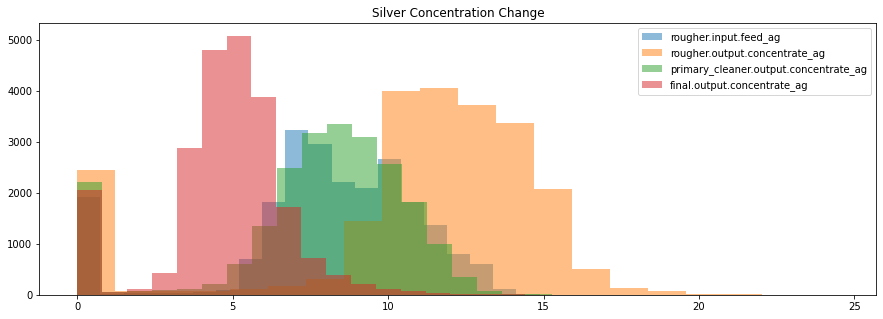

In [138]:
plt.figure(figsize = (15,5))
plot_concentrate('ag')
plt.title('Silver Concentration Change')

In [139]:
mean_concentrate('ag')

Average rougher.input.feed_ag      : 8.065715344767641
Average rougher.output.concentrate_ag      : 10.874483745395448
Average primary_cleaner.output.concentrate_ag      : 7.691651764297089
Average final.output.concentrate_ag      : 4.781559451695084


Ditemukan konsentrasi perak tiap tahapnya terdapat fluktuasi di mana permulaanya memiliki rata-rata nilai sebesar 8.07 dan output akhirnya memiliki nilai rata-rata sebesar 4.78. 

Text(0.5, 1.0, 'Lead Concentration Change')

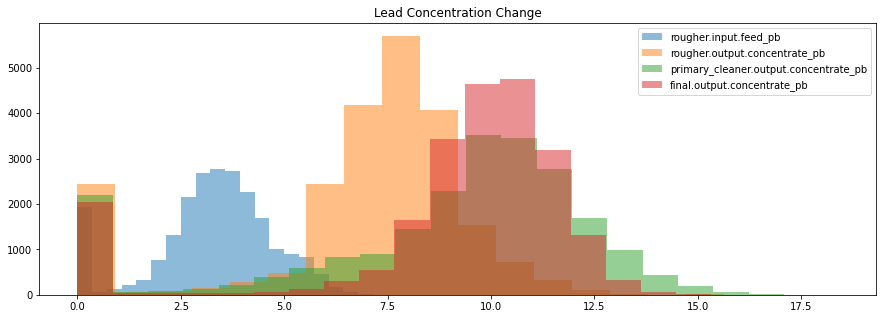

In [140]:
plt.figure(figsize = (15,5))
plot_concentrate('pb')
plt.title('Lead Concentration Change')

In [141]:
mean_concentrate('pb')

Average rougher.input.feed_pb      : 3.3056758107348885
Average rougher.output.concentrate_pb      : 6.900646225251443
Average primary_cleaner.output.concentrate_pb      : 8.921109840609049
Average final.output.concentrate_pb      : 9.095308105450266


Ditemukan konsentrasi timah tiap tahapnya meningkat terus dari inputnya dengan rata-rata 3.31 sampai akhirnya mencapai 9.10.

### Perbandingan distribusi ukuran partikel feed dalam training set dan test set

In [142]:
def filter_outlier(series):
    return series[series.between(series.quantile(0.01), series.quantile(0.99))]

def compare_train_test(feature):
    filter_outlier(df_train[feature]).plot.kde()
    filter_outlier(df_test[feature]).plot.kde()
    plt.legend(['train','test'])

In [143]:
from scipy.stats import levene

In [144]:
# Function untuk uji variansi
def levene_variance(series1, series2, alpha=0.05):
    p_value_levene = levene(series1, series2).pvalue
    print(f'P-Value: {p_value_levene}')
    print(f'Alpha  : {alpha}')
    if p_value_levene >= alpha:
        print('H0 Diterima: Kedua data memiliki variansi yang sama')
    else:
        print('H1 Diterima: Kedua data memiliki variansi yang tidak sama')

Untuk melihat perbandingan distribusi ukuran partikel feed pada training set dan test set, kita akan menggunakan uji variansi levene.

In [145]:
X_columns = df_test_final.drop(columns = ['date']).columns.values
y_columns = ['rougher.output.recovery', 'final.output.recovery']

X_train = df_train_final[X_columns].reset_index(drop = True)
y_train =  df_train_final[y_columns].reset_index(drop = True)

y_train.columns = [0, 1]

In [146]:
X_test = df_test_final[X_columns].reset_index(drop = True)

y_test = df_full[df_full['date'].isin(df_test_final['date'])][y_columns].reset_index(drop = True)
y_test.columns = [0, 1]

In [147]:
feeds = [column for column in X_train.columns if 'feed' in column]
feeds

['primary_cleaner.input.feed_size',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au']

Text(0.5, 1.0, 'Distribusi Ukuran Partikel Feed Utama Training dan Test Set Tanpa Outlier')

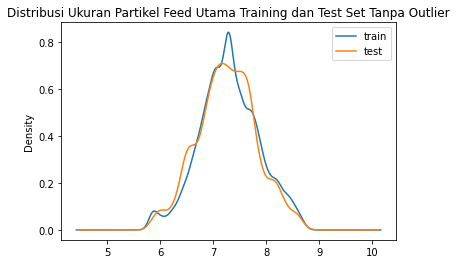

In [148]:
compare_train_test('primary_cleaner.input.feed_size')
plt.title('Distribusi Ukuran Partikel Feed Utama Training dan Test Set Tanpa Outlier')

In [149]:
levene_variance(X_train['primary_cleaner.input.feed_size'], X_test['primary_cleaner.input.feed_size'])

P-Value: 0.29160196970934205
Alpha  : 0.05
H0 Diterima: Kedua data memiliki variansi yang sama


Text(0.5, 1.0, 'Distribusi Partikel Feed Ag Training dan Test Set Tanpa Outlier')

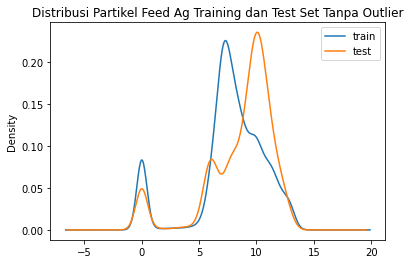

In [150]:
compare_train_test('rougher.input.feed_ag')
plt.title('Distribusi Partikel Feed Ag Training dan Test Set Tanpa Outlier')

In [151]:
levene_variance(X_train['rougher.input.feed_ag'], X_test['rougher.input.feed_ag'])

P-Value: 2.6414195173599137e-98
Alpha  : 0.05
H1 Diterima: Kedua data memiliki variansi yang tidak sama


Text(0.5, 1.0, 'Distribusi Partikel Feed Pb Training dan Test Set Tanpa Outlier')

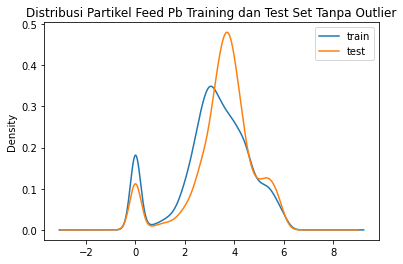

In [152]:
compare_train_test('rougher.input.feed_pb')
plt.title('Distribusi Partikel Feed Pb Training dan Test Set Tanpa Outlier')

In [153]:
levene_variance(X_train['rougher.input.feed_pb'], X_test['rougher.input.feed_pb'])

P-Value: 1.3539838760000156e-10
Alpha  : 0.05
H1 Diterima: Kedua data memiliki variansi yang tidak sama


Text(0.5, 1.0, 'Distribusi Kecepatan Partikel Feed Training dan Test Set Tanpa Outlier')

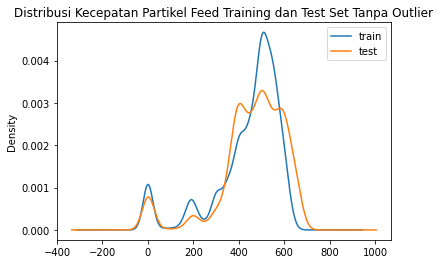

In [154]:
compare_train_test('rougher.input.feed_rate')
plt.title('Distribusi Kecepatan Partikel Feed Training dan Test Set Tanpa Outlier')

In [155]:
levene_variance(X_train['rougher.input.feed_rate'], X_test['rougher.input.feed_rate'])

P-Value: 2.5135369363321505e-138
Alpha  : 0.05
H1 Diterima: Kedua data memiliki variansi yang tidak sama


Text(0.5, 1.0, 'Distribusi Ukuran Partikel Feed Kasar Training dan Test Set Tanpa Outlier')

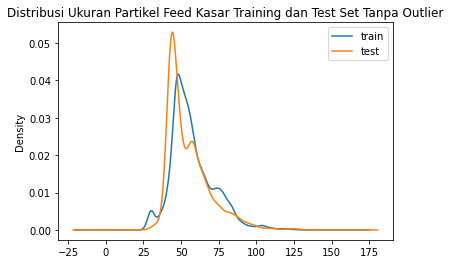

In [156]:
compare_train_test('rougher.input.feed_size')
plt.title('Distribusi Ukuran Partikel Feed Kasar Training dan Test Set Tanpa Outlier')

In [157]:
levene_variance(X_train['rougher.input.feed_size'], X_test['rougher.input.feed_size'])

P-Value: 0.09162100202519845
Alpha  : 0.05
H0 Diterima: Kedua data memiliki variansi yang sama


Text(0.5, 1.0, 'Distribusi Partikel Feed Sol Training dan Test Set Tanpa Outlier')

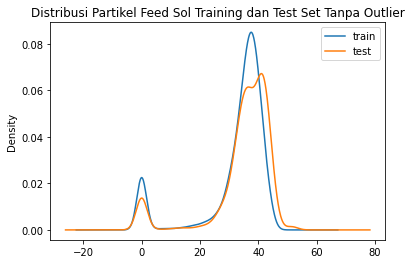

In [158]:
compare_train_test('rougher.input.feed_sol')
plt.title('Distribusi Partikel Feed Sol Training dan Test Set Tanpa Outlier')

In [159]:
levene_variance(X_train['rougher.input.feed_sol'], X_test['rougher.input.feed_sol'])

P-Value: 1.1402742319769376e-245
Alpha  : 0.05
H1 Diterima: Kedua data memiliki variansi yang tidak sama


Text(0.5, 1.0, 'Distribusi Partikel Feed Au Training dan Test Set Tanpa Outlier')

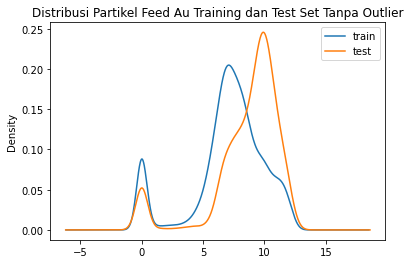

In [160]:
compare_train_test('rougher.input.feed_au')
plt.title('Distribusi Partikel Feed Au Training dan Test Set Tanpa Outlier')

In [161]:
levene_variance(X_train['rougher.input.feed_au'], X_test['rougher.input.feed_au'])

P-Value: 6.939145855792797e-44
Alpha  : 0.05
H1 Diterima: Kedua data memiliki variansi yang tidak sama


In [162]:
for column in feeds:
    print(column)
    levene_variance(X_train[column], X_test[column])
    print('--------------------')

primary_cleaner.input.feed_size
P-Value: 0.29160196970934205
Alpha  : 0.05
H0 Diterima: Kedua data memiliki variansi yang sama
--------------------
rougher.input.feed_ag
P-Value: 2.6414195173599137e-98
Alpha  : 0.05
H1 Diterima: Kedua data memiliki variansi yang tidak sama
--------------------
rougher.input.feed_pb
P-Value: 1.3539838760000156e-10
Alpha  : 0.05
H1 Diterima: Kedua data memiliki variansi yang tidak sama
--------------------
rougher.input.feed_rate
P-Value: 2.5135369363321505e-138
Alpha  : 0.05
H1 Diterima: Kedua data memiliki variansi yang tidak sama
--------------------
rougher.input.feed_size
P-Value: 0.09162100202519845
Alpha  : 0.05
H0 Diterima: Kedua data memiliki variansi yang sama
--------------------
rougher.input.feed_sol
P-Value: 1.1402742319769376e-245
Alpha  : 0.05
H1 Diterima: Kedua data memiliki variansi yang tidak sama
--------------------
rougher.input.feed_au
P-Value: 6.939145855792797e-44
Alpha  : 0.05
H1 Diterima: Kedua data memiliki variansi yang tidak

Dari hasil yang didapat, ditemukan **primary_cleaner.input.feed_size** dan **rougher.input.feed_size** pada training set dan test set memiliki variansi yang dapat dianggap sama.

**rougher.input.feed_ag**, **rougher.input.feed_pb**, **rougher.input.feed_rate**, **rougher.input.feed_sol** dan **rougher.input.feed_au** pada training set dan test set memiliki variansi yang tidak sama.

### Pertimbangkan total konsentrasi semua substansi di tahap yang berbeda: feed mentah, konsentrasi yang lebih kasar, dan konsentrasi akhir

In [163]:
features_input_concentrate = ['rougher.input.feed_au', 
                              'rougher.input.feed_ag',
                              'rougher.input.feed_pb',
                              'rougher.input.feed_sol']

features_rough_concentrate = ['rougher.output.concentrate_au', 
                              'rougher.output.concentrate_ag',
                              'rougher.output.concentrate_pb',
                              'rougher.output.concentrate_sol']

features_final_concentrate = ['final.output.concentrate_au', 
                              'final.output.concentrate_ag',
                              'final.output.concentrate_pb',
                              'final.output.concentrate_sol']

<AxesSubplot:>

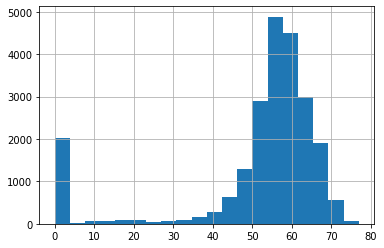

In [164]:
df_full[features_input_concentrate].sum(axis = 1).hist(bins = 20)

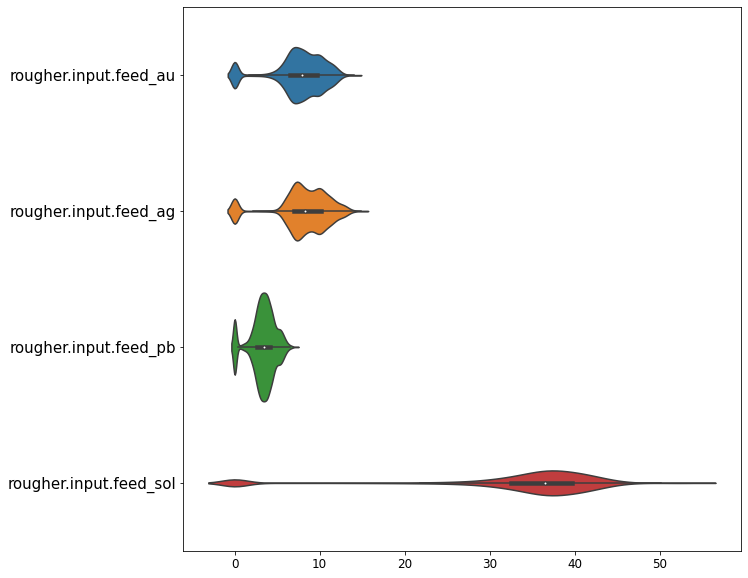

In [165]:
plt.figure(figsize=(10,10))
sns.violinplot(data = df_full[features_input_concentrate], orient = 'h')

plt.xticks(fontsize=12)
plt.yticks(fontsize=15)

plt.show()

In [166]:
df_full[features_input_concentrate].mean()

rougher.input.feed_au      7.565838
rougher.input.feed_ag      8.065715
rougher.input.feed_pb      3.305676
rougher.input.feed_sol    33.276016
dtype: float64

<AxesSubplot:>

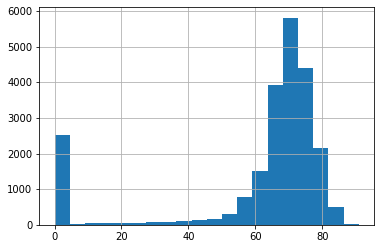

In [167]:
df_full[features_rough_concentrate].sum(axis = 1).hist(bins = 20)

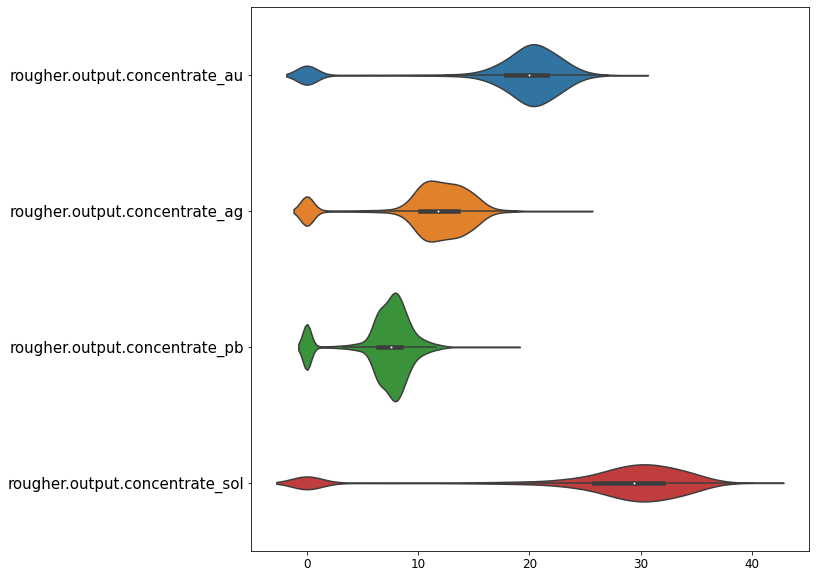

In [168]:
plt.figure(figsize=(10,10))
sns.violinplot(data = df_full[features_rough_concentrate], orient = 'h')

plt.xticks(fontsize=12)
plt.yticks(fontsize=15)

plt.show()

In [169]:
df_full[features_rough_concentrate].mean()

rougher.output.concentrate_au     17.879538
rougher.output.concentrate_ag     10.874484
rougher.output.concentrate_pb      6.900646
rougher.output.concentrate_sol    26.095508
dtype: float64

<AxesSubplot:>

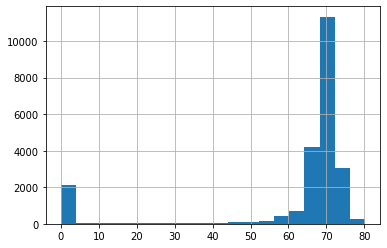

In [170]:
df_full[features_final_concentrate].sum(axis = 1).hist(bins = 20)

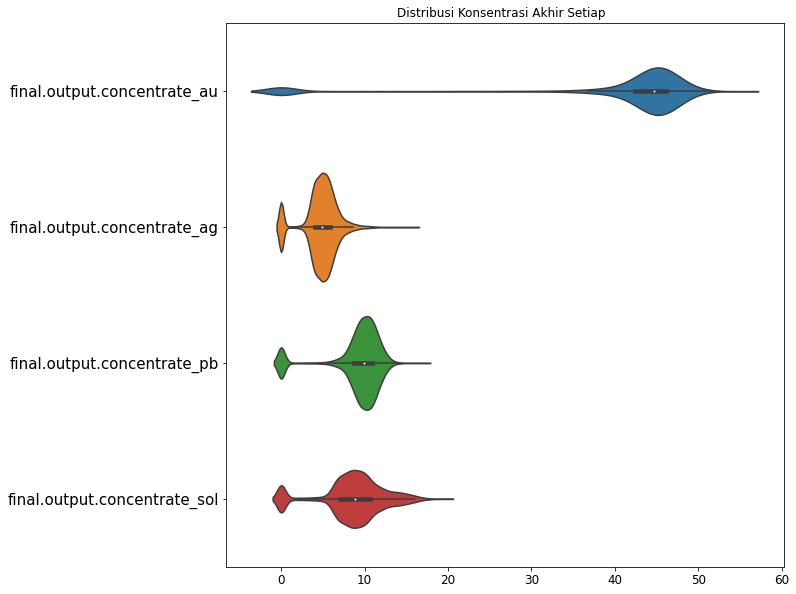

In [171]:
plt.figure(figsize=(10,10))
sns.violinplot(data = df_full[features_final_concentrate], orient = 'h')
plt.title('Distribusi Konsentrasi Akhir Setiap  ')
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)

plt.show()

In [172]:
df_full[features_final_concentrate].mean()

final.output.concentrate_au     40.001172
final.output.concentrate_ag      4.781559
final.output.concentrate_pb      9.095308
final.output.concentrate_sol     8.640317
dtype: float64

Dari hasil yang didapat, ditemukan dibutuhkan konsentrasi besar dalam sol yang besar dengan rata-rata 33.28. Konsentrasi ini berkurang dari setiap tahap di mana akhirnya sebesar 8.64.

Sementara itu, konsentrasi emas setiap tahapnya bertambah terus dari 7.57 sampai 40.00.

In [173]:
threshold = 0.1
df_train = df_train[df_train[features_input_concentrate].sum(axis = 1) > threshold]
df_train = df_train[df_train[features_rough_concentrate].sum(axis = 1) > threshold]
df_train = df_train[df_train[features_final_concentrate].sum(axis = 1) > threshold]

print(df_train.shape)

df_full_test = df_full[df_full['date'].isin(df_test['date'])].reset_index(drop = True)

# df_test = df_test[df_full_test[features_input_concentrate].sum(axis = 1) > threshold]
# df_test = df_test[df_full_test[features_rough_concentrate].sum(axis = 1) > threshold]
# df_test = df_test[df_full_test[features_final_concentrate].sum(axis = 1) > threshold]

print(df_test.shape)

(14601, 87)
(5856, 53)


## Feature Engineering

### Model Selection

In [174]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold


In [175]:
X_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [176]:
y_train.head()

,0,1
0,87.107763,70.541216
1,86.843261,69.266198
2,86.842308,68.116445
3,87.226430,68.347543
4,86.688794,66.927016


In [177]:
X_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [178]:
y_test.head()

,0,1
0,89.993421,70.273583
1,88.089657,68.910432
2,88.412756,68.143213
3,87.360133,67.776393
4,83.236367,61.467078


In [179]:
X_test.shape

(5856, 52)

In [180]:
def smape(y_true, y_pred):
    error = (y_true - y_pred).abs()
    scale = (y_true.abs() + y_pred.abs()) / 2
    
    return (error / scale).mean() * 100


def smape_weighted(y_true, y_pred):
    rougher = smape(y_true[0], y_pred[0])
    final = smape(y_true[1], y_pred[1])
    
    return 0.25 * rougher + 0.75 * final


In [181]:
def score_model(model, cv=4):
    scores = []
    scores_test = []
    for subtrain_index, valid_index in KFold(n_splits=cv).split(X_train):
        
        X_subtrain = X_train.loc[subtrain_index].reset_index(drop=True)
        y_subtrain = y_train.loc[subtrain_index].reset_index(drop=True)
        
        X_valid = X_train.loc[valid_index].reset_index(drop=True)
        y_valid = y_train.loc[valid_index].reset_index(drop=True)
        
        model.fit(X_subtrain, y_subtrain)
        pred_valid = pd.DataFrame(model.predict(X_valid))
        pred_test = pd.DataFrame(model.predict(X_test))
        
        scores.append(smape_weighted(y_valid, pred_valid))
        scores_test.append(smape_weighted(y_test, pred_test))
        
    return round(pd.Series(scores).mean(), 2),  round(pd.Series(scores_test).mean(), 2)

#### Linear Regression

In [182]:
model = LinearRegression()
lr_score_valid, lr_score_test = score_model(model)
print('LR validation score:', lr_score_valid,'%', '    LR test score:', lr_score_test,'%')

LR validation score: 12.65 %     LR test score: 11.24 %


#### Decision Tree Regressor

In [183]:
model = DecisionTreeRegressor(max_depth=10)
dt_score_valid, dt_score_test = score_model(model)
print('DT validation score:', dt_score_valid, '%', '    DT test score:', dt_score_test,'%')


DT validation score: 14.7 %     DT test score: 13.75 %


In [192]:
model = DecisionTreeRegressor(max_depth=10)
dt_score_valid, dt_score_test = score_model(model)
print('DT validation score:', dt_score_valid, '%', '    DT test score:', dt_score_test,'%')


DT validation score: 14.59 %     DT test score: 14.84 %


#### Random Forest Regressor

In [184]:
model = RandomForestRegressor(n_estimators=10, max_depth=10)
rf_score_valid, rf_score_test = score_model(model)
print('RF validation score:', rf_score_valid, '%','    RF test score:', rf_score_test,'%')

RF validation score: 12.2 %     RF test score: 11.05 %


#### Kesimpulan Umum

Dari hasil yang ditemukan, didapatkan model-model tersebut menghasilkan:
- Linear Regression       : skor validasi 12.65% dan skor test sebesar 11.24%
- Decision Tree Regressor : skor validasi 14.7% dan skor test sebesar 13.75% 
- Random Forest Regressor : skor validasi 12.2% dan skor test sebesar 11.05%.

## Kesimpulan

Proyek ini dilakukan untuk mencari perolehan konsentrat yang lebih kasar **rougher.output.recovery** dan perolehan konsentrat akhir **final.output.recovery**. 

Analisis dimulai dari melihat info keseluruhan dari setiap dataset dan ditemukan terdapat banyak nilai yang hilang yang perlu diisi pada fitur-fitur dan pada df_test terdapat 34 kolom yang hilang pada dataset tersebut. 

Selanjutnya, kita menghitung MAE perolehan emas dengan rumus yang diberikan. Perolehan emas yang didapat dari rumus lalu dicari MAE dan ditemukan terdapat masalah. Pada hasil perolehan emas dari rumus, terdapat beberapa perhitungan yang menghasilkan nilai missing, INF dan -INF. Nilai-nilai tersebut akan diubah menjadi 0 untuk agar MAE dapat dihitung dan didapatkan nilai MAE sebesar 48.735. Namun, jika nilai bermasalah tersebut dibiarkan maka nilai MAE menjadi 9.303e-15.

Untuk mengisi nilai hilang, pertama kita mengambil kolom yang terdapat pada df_test saja karena kolom-kolom tersebut adalah fitur-fitur yang akan digunakan dalam prediksi modeling nanti. df_train dengan fitur yang terpilih tersebut kemudian digabungkan dengan df_test untuk mencari median dari setiap fitur dengan nilai hilang agar tidak ada masalah dalam pengisian nilai hilang pada kedua dataset tersebut. Dataset dipisah kembali dengan cara melihat **rougher.output.recovery** terisi atau tidak. Nilai hilang pada **rougher.output.recovery** menunjukan baris tersebut terdapat pada dataset df_test dan jika terisi maka baris tersebut terdapat pada df_train.

Lalu kita melihat bagaimana perubuhan konsentrasi logam (Au, Ag, Pb), pada setiap tahap pemurniannya. Kita menemukan:
- Emas: Terdapat peningkatan konsentrasi tiap tahapnya:
        - rougher.input          :7.57
        - rougher.output         :17.88
        - primary_cleaner.output :29.21
        - final.output           :40.00 
        
- Perak: Terdapat fluktuasi konsentrasi tiap tahapnya:
        - rougher.input          :8.07
        - rougher.output         :10.87
        - primary_cleaner.output :7.69
        - final.output           :4.78
        
- Timbal: Terdapat fluktuasi konsentrasi tiap tahapnya:
        - rougher.input          :3.31
        - rougher.output         :6.90
        - primary_cleaner.output :8.92
        - final.output           :9.10

Selanjutnya, kita melihat bagaimana variansi perbandingan distribusi ukuran partikel feed dalam training set dan test set.

Dari hasil yang didapat, ditemukan **primary_cleaner.input.feed_size** dan **rougher.input.feed_size** pada training set dan test set memiliki variansi yang dapat dianggap sama.

**rougher.input.feed_ag**, **rougher.input.feed_pb**, **rougher.input.feed_rate**, **rougher.input.feed_sol** dan **rougher.input.feed_au** pada training set dan test set memiliki variansi yang tidak sama.

Berikut, kita akan mempertimbangkan total konsentrasi semua substansi di tahap yang berbeda, yakni:
- feed mentah:
    - rougher.input.feed_au      7.565838
    - rougher.input.feed_ag      8.065715
    - rougher.input.feed_pb      3.305676
    - rougher.input.feed_sol    33.276016
    
    
- konsentrasi yang lebih kasar:
    - rougher.output.concentrate_au     17.879538
    - rougher.output.concentrate_ag     10.874484
    - rougher.output.concentrate_pb      6.900646
    - rougher.output.concentrate_sol    26.095508
    
    
- konsentrasi akhir:
    - final.output.concentrate_au     40.001172
    - final.output.concentrate_ag      4.781559
    - final.output.concentrate_pb      9.095308
    - final.output.concentrate_sol     8.640317

Modeling data dilakukan dengan membuat fungsi yang dapat menghitung sMAPE sesuai dengan rumus yang diberikan. Dalam modeling, akan dilakukan cross-validation untuk memilih model terbaik.

Dari hasil yang ditemukan, didapatkan model-model tersebut menghasilkan:
- Linear Regression       : skor validasi 12.65% dan skor test sebesar 11.24%
- Decision Tree Regressor : skor validasi 14.7% dan skor test sebesar 13.75% 
- Random Forest Regressor : skor validasi 12.2% dan skor test sebesar 11.05%

